### <b>Washington State Crash Event Analysis</b>
#### --- by 

In [376]:
import pandas as pd
import numpy as np
import regex as re

import time

import os

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 9)


#### <b>1. Explorative Data Analysis</b></br>
##### <b>1.1 Introduction to Datasets</b></br>
- <b>df_data_main</b>: The original data set with an expanded column that stores the zipcode of the place where the accident occured</br>
- <b> df_metadata_crashtype</b>: Derived from the table 6 of the original dataset. This dataframe contains all the metainfo about a category of crashtype</br>

In [377]:
dir = os.path.abspath(os.path.dirname(os.getcwd())) + '/data/'

df_data_main = pd.read_csv(
    dir + '/output/data_with_zipcode.csv').drop(axis=1, labels='Unnamed: 0')
df_data_main.event_zipcode = df_data_main.event_zipcode.astype(
    str)   # convert the default float type values into str

df_metadata_crashtype = pd.read_csv(
    dir + '/output/crash_type.csv').set_index(keys='type_index')

df_metadata_driver_factor = pd.read_csv(
    dir + '/output/driver_behavioral_factors.csv').drop(labels='Unnamed: 0', axis=1)


df_metadata_race = pd.read_csv(dir + '/output/race_code.csv')

df_data_main.shape

C:\Users\Chaconne\AppData\Local\Temp\ipykernel_32296\2748844850.py:3: DtypeWarning: Columns (22,23,24,302,304) have mixed types. Specify dtype option on import or set low_memory=False.
  df_data_main = pd.read_csv(


(4132, 306)

##### <b>1.2 Data Cleaning</b>

In [378]:
# drop rows which do not have a valid event zipcode

has_no_zipcode = df_data_main.event_zipcode.map(lambda v: v == 'nan')
df_data_main = df_data_main[df_data_main.event_zipcode != 'nan']
df_data_main.shape

(4132, 306)

In [379]:
# drop rows which do not have a person zipcode

df_data_main.dzip = df_data_main.dzip.map(
    lambda n: 0 if n == 0 else 0 if pd.isna(n) else int(n)
)

# valid zip codes are all 5 digit so we filter out those with less than 5 digits
df_data_main = df_data_main[(df_data_main.dzip > 10000) & (df_data_main.dzip <= 99950)]
df_data_main.dzip = df_data_main.dzip.astype(str)
df_data_main.shape

(3996, 306)

In [380]:
# clean the age column

age_filter = filter(lambda v: v > 0 and v < 100, df_data_main.age)
age_mean = round(np.mean(list(age_filter), dtype=float), 0)

df_data_main.age = df_data_main.age.map(
    lambda v: age_mean if v < 0 or v >= 100 else v
)

#### <b> 2. Solutions
##### <b>2.1 Among drivers involved in fatal crashes, what proportion are involved in crashes in communities where they live?</b>

25.4780% of the drivers are from the community where the accident occured


<AxesSubplot:title={'center':'proportion of non-resident vs. resident crashes'}>

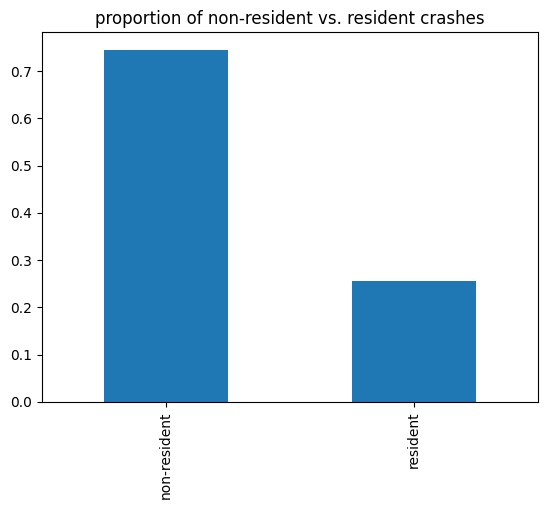

In [381]:
df_data_main['is_resident'] = df_data_main.index.map(
    lambda i: df_data_main.event_zipcode[i] == df_data_main.dzip[i]
)

df_data_main['is_driver'] = df_data_main.index.map(
    lambda i: df_data_main.loc[i,
                               'ptype'] == 1 and df_data_main.loc[i, 'vnumber'] == 1
)

prop = len(df_data_main[(df_data_main.is_resident == True) & (
    df_data_main.is_driver == True)]) / float(len(df_data_main[df_data_main.is_driver == True]))

print('{prop:.4f}% of the drivers are from the community where the accident occured'.format(
    prop=prop * 100))

pd.Series([1 - prop, prop, ], index=['non-resident', 'resident']).plot(kind = 'bar', title = 'proportion of non-resident vs. resident crashes')

Based on our analysis, <b>25.478%</b> of the drivers are from the community where the accident occured.

##### <b>2.2 Are there differences in the <u>crash types</u> in those crashes among “residents” versus those deemed to be not “from” the area?</b>
- We will first take a look at the types of crashes among residents versus non-residents drivers. To that end, we load the metadata regarding crash types.

In [382]:
# this dataframe stores the meta info of the variable crashtype
df_metadata_crashtype.head()

,crash_type,category
type_index,,
0,No Impact,NOT CATEGORIZED
1,Drive Off Road,SINGLE DRIVER
2,Control/Traction Loss,SINGLE DRIVER
3,"Avoid Collision with Vehicle, Pedestrian, Animal",SINGLE DRIVER
4,Specifics Other,SINGLE DRIVER


In [383]:
map_crashtype_category = {  # maps a crashtype to its category
    k: v for k, v in zip(df_metadata_crashtype.index, df_metadata_crashtype.category)
}

map_crashtype_eng = {   # maps a crashtype index to its actual meaning
    k: v for k, v in zip(df_metadata_crashtype.index, df_metadata_crashtype['crash_type'])
}

df_data_main['crash_category'] = df_data_main.crashtype.map(map_crashtype_category)
df_data_main['crashtype_eng'] = df_data_main.crashtype.map(map_crashtype_eng)

In [384]:
# count the occurances of each crashtype for both the residenr and non-resident groups
df_data_crash = df_data_main.groupby(by=['crashtype', 'is_resident']).agg(
    case_count=pd.NamedAgg(column='par', aggfunc=len),
).reset_index()

# temporary dataframe for calculating total by is_resident
df_temp = df_data_main.groupby('is_resident').par.agg('count')
# print(df_temp)
non_resident_event_count = float(df_temp.iloc[0])
resident_event_count = float(df_temp.iloc[1])
del df_temp


def get_case_proportion(case_index: int, crash_dataframe: pd.DataFrame) -> float:
    is_resident = crash_dataframe.loc[case_index, 'is_resident']
    case_count = crash_dataframe.loc[case_index, 'case_count']
    if is_resident:
        ratio = case_count / resident_event_count
    else:
        ratio = case_count / non_resident_event_count
    return ratio


df_data_crash['case_proportion'] = df_data_crash.index.map(
    lambda i: get_case_proportion(i, df_data_crash))

df_data_crash[:8]

,crashtype,is_resident,case_count,case_proportion
0,0,False,18,0.005958
1,0,True,4,0.004103
2,1,False,241,0.079775
3,1,True,95,0.097436
4,2,False,99,0.032771
5,2,True,33,0.033846
6,3,False,2,0.000662
7,5,False,1,0.000331


- From previous analysis we know that the occurences of non-resident driver car crash outnumbers that of resident drivers', comparison based on counts of occurences thus cannot clearly show the different patterns across resident and non-resident drivers.
- The following pivot table compares the proportion of crashtypes in both the driver groups and shows the crashtypes the difference of which across the two groups are of the top 5.

In [385]:
df_crash_pivoted = df_data_crash.pivot(
    index='crashtype', columns='is_resident', values=['case_proportion'])

df_crash_pivoted['prop_diff'] = df_crash_pivoted[(
    'case_proportion', False)] - df_crash_pivoted[('case_proportion', True)]
df_crash_pivoted.sort_values(by='prop_diff', ascending=False, inplace=True)
df_crash_pivoted = df_crash_pivoted.fillna(0)

df_crash_pivoted['crashtype_eng'] = df_crash_pivoted.index.map(map_crashtype_eng)
df_crash_pivoted[:5]

case_proportion           prop_diff               crashtype_eng
is_resident           False      True                                      
crashtype                                                                  
98                 0.183714  0.134359  0.049355           Other Crash Type 
50                 0.068189  0.050256  0.017933  Lateral Move (Left/Right) 
28                 0.008606  0.001026  0.007581     Decelerating (Slowing) 
25                 0.016220  0.009231  0.006989     Slower, Going Straight 
52                 0.013572  0.007179  0.006392            Specifics Other

- According to the pivot table, the largest difference of case proportion appears in the crash types<b>98, 50, 28, 25,52</b>, which are <b>Other Crash Type,  Lateral Move (Left/Right), Decelerating (Slowing), and Slower, Going Straight</b>.</br>
- Filtering out <b>Other Crash Type</b> and <b>Specifics Other</b>, which represent uncategorized crash types, we then conclude that <b>Lateral Move, Decelerating, and Slower, Going Straight</b> are the most frequent crash types.

<AxesSubplot:xlabel='crashtype'>

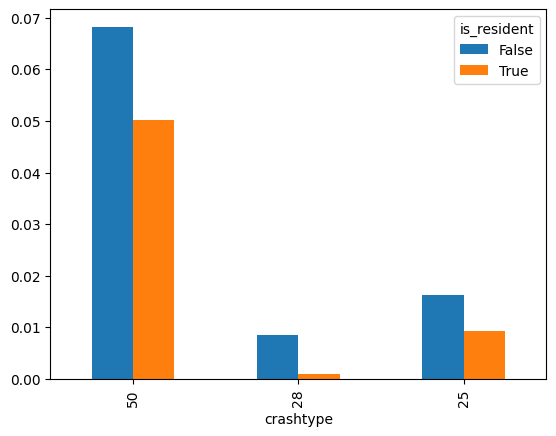

In [386]:
df_crash_pivoted.case_proportion[1:4].plot(kind = 'bar')

<AxesSubplot:>

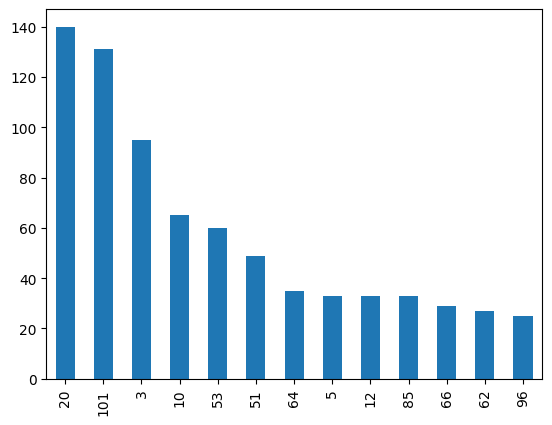

In [387]:
resident_crashes = df_data_crash[df_data_crash.is_resident]

resident_crashes[
    resident_crashes.case_count >= resident_crashes.case_count.quantile(.75)
].case_count.sort_values(ascending=False).plot(kind = 'bar')

<AxesSubplot:>

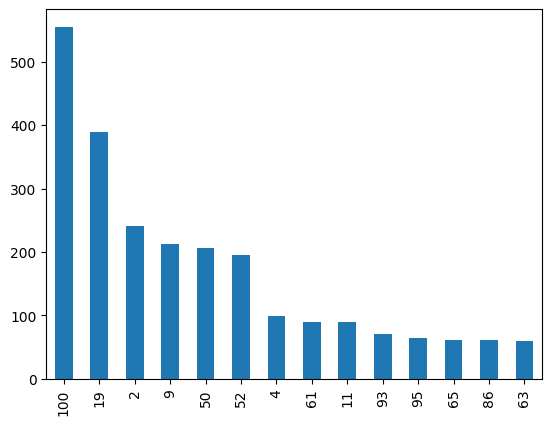

In [388]:
non_resident_crashes = df_data_crash[df_data_crash.is_resident == False]

non_resident_crashes[
    non_resident_crashes.case_count >= non_resident_crashes.case_count.quantile(.75)
].case_count.sort_values(ascending=False).plot(kind = 'bar')

##### <b>2.3 Are there differences in the <u>behavior factors</u> in those crashes among “residents” versus those deemed to be not “from” the area?

In [389]:
df_metadata_driver_factor = df_metadata_driver_factor.loc[
    df_metadata_driver_factor.effect_end >= df_data_main.year.min(), :
]   # filter out factors that do not take effect during the timeframe of the dataset

df_metadata_driver_factor = df_metadata_driver_factor.sort_values(
    by='factor_index', ascending=True).reset_index(drop=True)
df_metadata_driver_factor

,factor_index,driver_factor,effect_start,effect_end,factor_category
0,0,No factors identified for this driver,0,9999,default
1,4,Reaction to/Failure to take Drugs/Medication,0,9999,Physical/Mental Condition
2,6,Careless Driving,2012,9999,Physical/Mental Condition
3,8,Aggressive Driving Road Rage,2004,9999,Physical/Mental Condition
...,...,...,...,...,...
76,94,Emergency Medical Service Personnel,0,2019,Possible Distraction Inside Vehicle
77,95,Fire Personnel,0,2019,Possible Distraction Inside Vehicle
78,96,Tow Operator,0,2019,Possible Distraction Inside Vehicle
79,97,"Transportation i.e. maintenance workers, safte...",0,2019,Possible Distraction Inside Vehicle


In [390]:
def sum_driver_factor(index: int, df: pd.DataFrame):
    # first conerted to int to remove trailing decimal zero
    joint = '|'.join(df.loc[index, 'drf1':'drf4'].astype(int).astype(str))
    return re.sub(pattern=r'\|0', string=joint, repl='')


df_data_main.loc[:, 'drf1':'drf4'] = df_data_main.loc[:, 'drf1':'drf4'].fillna(0)     # in this case, na suggests no factor rather than the missing of value
df_data_main['drf'] = df_data_main.index.map(lambda i:  sum_driver_factor(i, df_data_main))

# drop the original component columns as we already acquired the summed up one
df_data_main.drop(axis=1, labels=['drf1', 'drf2', 'drf3', 'drf4'], inplace=True)

In [391]:
def get_factor_levels(factor_col):
    res = []
    for val in factor_col:
        val_split = val.split('|')
        for v in val_split:
            res.append(v)
    return sorted(np.unique(res))   # sort the levels


# stores the distinct values of drf
drf_distinct_vals = get_factor_levels(df_data_main.drf)


def factor_to_dummy(factor_col, level):
    col_len = len(factor_col)

    data_dict = {
        lv: [0] * col_len for lv in level
    }
    for i in range(col_len):
        keys = factor_col[i].split('|')
        for key in keys:
            data_dict[key][i] = 1
    return pd.DataFrame(data_dict)


df_drf_dist = factor_to_dummy(df_data_main.drf.values, drf_distinct_vals)
df_drf_dist.insert(0, 'is_resident', df_data_main.is_resident)
df_drf_dist = df_drf_dist.groupby('is_resident').agg('sum')
# get corresponding proportion
df_drf_dist.loc[0, :] = df_drf_dist.loc[0, :] / sum(df_drf_dist.loc[0, :])
df_drf_dist.loc[1, :] = df_drf_dist.loc[1, :] / sum(df_drf_dist.loc[1, :])
df_drf_dist = df_drf_dist.transpose()


df_drf_dist.columns = ['non-resident', 'resident']
df_drf_dist['diff'] = df_drf_dist['non-resident'] - df_drf_dist['resident']
df_drf_dist.sort_values(by='diff', inplace=True, ascending=False)
df_drf_dist.drop('diff', inplace=True, axis=1)
df_drf_dist.set_index(pd.Series(df_drf_dist.index, name='drf', dtype=int), inplace=True)
df_drf_dist[:4]

,non-resident,resident
drf,,
28,0.070527,0.059838
39,0.033970,0.025355
38,0.061792,0.055781
8,0.012617,0.010142


<AxesSubplot:xlabel='drf'>

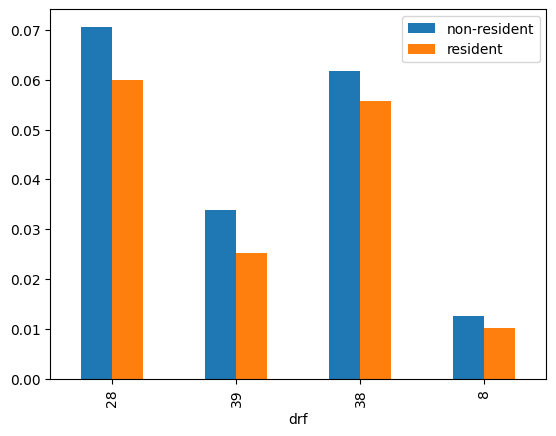

In [392]:
df_drf_dist[:4].plot(kind='bar')

- The table above suggests that compared to resident drivers, non-resident drviers are much more likely to encounter accidents that result from the behavioral factor <b>28</b>, that is, <b>improper lane use</b>.

- The following blocks focus on the analysis of <b>distraction factors</b>. As the distraction index 0 means not distracted, and index 96 not reported, we merge these two categories into one.

In [393]:
df_data_main.loc[:, 'distract1': 'distract6'] = df_data_main.loc[:, 'distract1': 'distract6'].fillna(0)


def sum_distract_factors(ind: int, df: pd.DataFrame):
    return re.sub(string="|".join(df.loc[ind, 'distract1': 'distract6'].astype(int).astype(str)), pattern=r'\|0', repl='')


df_data_main['distract'] = df_data_main.index.map(
    lambda i: re.sub(string=sum_distract_factors(i, df_data_main), repl='0', pattern='96')
)

df_data_main.drop(axis=1, labels=[
                  'distract1', 'distract2', 'distract3', 'distract4', 'distract5', 'distract6'], inplace=True)
df_data_main.distract.value_counts(ascending=False)


0       3443
92       308
93       140
12        20
        ... 
5|93       1
14         1
3|6        1
97         1
Name: distract, Length: 20, dtype: int64

In [394]:
distinct_distract = get_factor_levels(df_data_main.distract)

df_distract = factor_to_dummy(df_data_main.distract.values, distinct_distract)
df_distract.insert(0, column='is_resident', value=df_data_main.is_resident)
df_distract = df_distract.groupby('is_resident').agg('sum')

df_distract.loc[0, :] = df_distract.loc[0, :] / sum(df_distract.loc[0, :])
df_distract.loc[1, :] = df_distract.loc[1, :] / sum(df_distract.loc[1, :])

df_distract = df_distract.transpose()
df_distract.columns = ['non-resident', 'resident']
df_distract['diff'] = df_distract['non-resident'] - df_distract['resident']
df_distract.sort_values(by='diff', inplace=True, ascending=False)
df_distract.drop('diff', inplace=True, axis=1)
df_distract.set_index(
    pd.Series(df_distract.index, name='distract_factor', dtype=int), inplace=True)
df_distract[:5]

,non-resident,resident
distract_factor,,
93,0.038553,0.026652
1,0.004777,0.002132
12,0.005800,0.003198
5,0.001365,0.000000
13,0.001365,0.000000


- The analysis of distract factors shows that compared to resident drivers, non-resident drivers in fatal crash event are more likely to be involved with disctract factors 93, 1, 12, 5, and 13, which are <b>inattention, looked but did not see, distracted by outside person, talking or listening to phone, and eating or drinking.

##### <b>2.4 Are there specific resident ZIP Codes that tend to produce higher-risk drivers that are involved in fatal crashes at a higher rate?</b>

In [395]:
df_data_by_zip = df_data_main[df_data_main.is_driver == True].groupby('dzip').agg(
    case_count=pd.NamedAgg(column='par', aggfunc=len),
    case_proportion=pd.NamedAgg(
        column='par', aggfunc=lambda c: len(c) / len(df_data_main.index))
)
df_data_by_zip.sort_values(ascending=False, inplace=True, by='case_proportion')

df_data_by_zip.describe()

,case_count,case_proportion
count,584.000000,584.000000
mean,4.388699,0.001098
std,4.758087,0.001191
min,1.000000,0.000250
25%,1.000000,0.000250
50%,2.000000,0.000501
75%,6.000000,0.001502
max,28.000000,0.007007


In [396]:
risky_zipcode = df_data_by_zip[
        df_data_by_zip.case_count >= df_data_by_zip.case_count.mean() + 3 * df_data_by_zip.case_count.std()	
    ].index             #  filtering mean + 3 * sigma based on proportion
risky_zipcode

Index(['98444', '98584', '99301', '98404', '98003', '98902', '98022', '98901',
       '98387', '98391', '98837'],
      dtype='object', name='dzip')

<AxesSubplot:ylabel='case_count'>

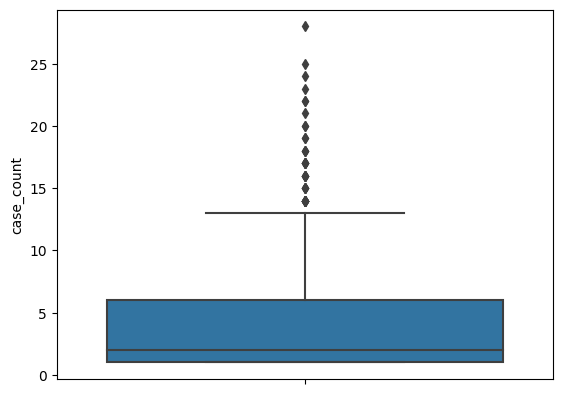

In [397]:
sns.boxplot(y=df_data_by_zip.case_count)

<AxesSubplot:xlabel='case_count', ylabel='Count'>

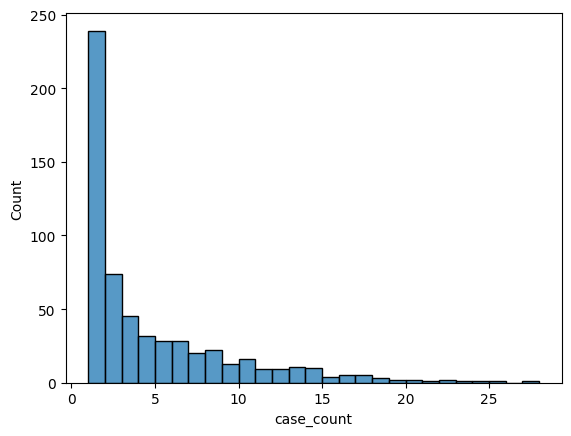

In [398]:
sns.histplot(x=df_data_by_zip.case_count, binwidth=1)

- Both the boxplot and histogram suggest that the distribution of case proportion across zipcodes follows Pareto distribution. This implies that the few areas account for most of the risky drivers. In other words, <b>there are specific zip codes that produce risky drivers at a significantly higher rate</b>.
- The high-risk zip codes are: <b>'98444', '98584', '99301', '98404', '98003', '98902', '98022', '98901',
       '98387', '98391', '98837'</b>.

##### <b>2.5 What are the population demographics of these high-risk driver producing ZIP Codes?</b>

In [399]:
# filter records related to risky zipcodes

# create a column to indicate whether the driver's community zipcode is considered high-risk
df_data_main['is_risky_dzip'] = df_data_main.index.map(lambda index: df_data_main.loc[index, 'dzip'] in risky_zipcode)

df_data_risky_zipcode = df_data_main.loc[
    df_data_main.index.map(lambda index: df_data_main.loc[index, 'is_risky_dzip'] and df_data_main.loc[index, 'is_driver']), :
]

print(df_data_risky_zipcode.shape)
df_data_risky_zipcode.head()

(243, 303)


,year,case,par,repjur,crash_dt,crash_tm,accday,accmon,holiday,county,...,IntCoRoadName,IntCoMP,event_zipcode,is_resident,is_driver,crash_category,crashtype_eng,drf,distract,is_risky_dzip
13,2017,10,E632128,8.0,01/08/2017,19:05,8,1,0.0,45,...,NaN,NaN,98546,False,True,"SAME TRAFFICWAY, OPPOSITE DIRECTION",Lateral Move (Left/Right),28,0,True
59,2017,40,E633587,25.0,01/16/2017,15:51,16,1,0.0,33,...,NaN,NaN,98022,True,True,SINGLE DRIVER,Drive Off Road,0,0,True
65,2017,43,E639820,1.0,02/01/2017,5:45,1,2,0.0,5,...,NaN,NaN,99345,False,True,"SAME TRAFFICWAY, OPPOSITE DIRECTION",Specifics Other,28|87,0,True
109,2017,75,E648586,35.0,03/04/2017,22:55,4,3,0.0,53,...,NaN,NaN,98444,True,True,"CHANGING TRAFFICWAY, VEHICLE TURNING",Initial Opposite Directions (Left/Right),38,0,True
118,2017,80,E651585,129.0,03/13/2017,13:03,13,3,0.0,53,...,NaN,NaN,98424,False,True,"SAME TRAFFICWAY, SAME DIRECTION",Slower,0,0,True


Text(0.5, 1.0, 'age distribution')

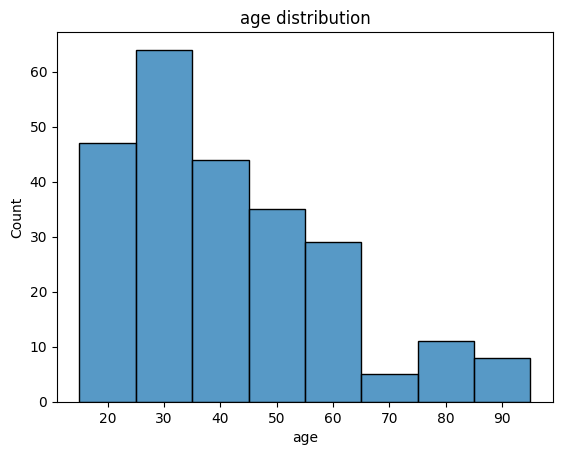

In [400]:
sns.histplot(x=df_data_risky_zipcode.age, binwidth=10, ).set_title('age distribution')

In [401]:
df_data_risky_zipcode.age.describe()

count    243.000000
mean      40.506173
std       17.937534
min       15.000000
25%       27.000000
50%       36.000000
75%       52.000000
max       89.000000
Name: age, dtype: float64

- As the histogram of age suggests, age distribution of risky drivers is significantly skewed to the right. <b>Drivers under the age of 36 account for 50% of the total crash events</b>.

C:\Users\Chaconne\AppData\Local\Temp\ipykernel_32296\461128785.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_risky_zipcode.sex = df_data_risky_zipcode.sex.map(lambda s: 3 if s != 1 and s != 2 else s).map(


<AxesSubplot:title={'center':'sex distribution'}, xlabel='sex'>

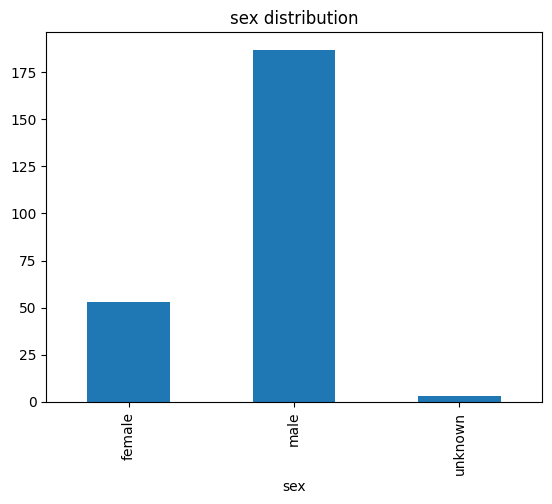

In [402]:
df_data_risky_zipcode.sex = df_data_risky_zipcode.sex.map(lambda s: 3 if s != 1 and s != 2 else s).map(
    {1: 'male', 2: 'female', 3: 'unknown'}
)

df_data_risky_zipcode.groupby('sex').agg('count').par.plot(kind='bar', title = 'sex distribution', )

- Most of the drivers who come from the high-risk zip code areas are male.
- Lastly, we analyze the demographical features of these high-risk instances.

##### <b>Output Cleaned Dataset for Visualization</b>

In [407]:
df_data_main.to_csv(dir + 'output/data_vis.csv')